# Combinando Python Notebooks con R y ggplot

En el presente tutorial explicaré como hacer para combinar

In [165]:
import numpy as np
import pandas as pd
import rpy2

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from scipy.stats import mode

%matplotlib inline
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:
%%R

library(ggplot2)
library(reshape2)

In [104]:
titanic = pd.read_csv('./data/titanic.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


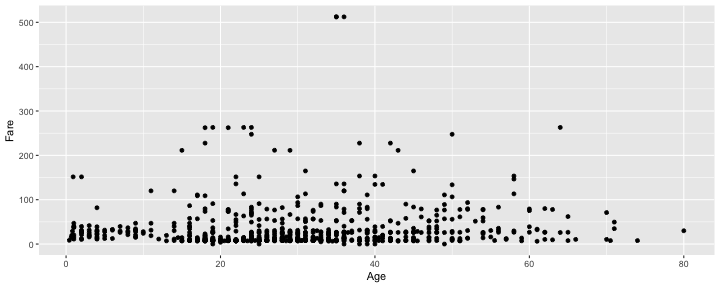

In [82]:
%%R -i titanic -w 10 -h 4 -u in

ggplot(titanic, aes(x=Age, y=Fare)) + geom_point()

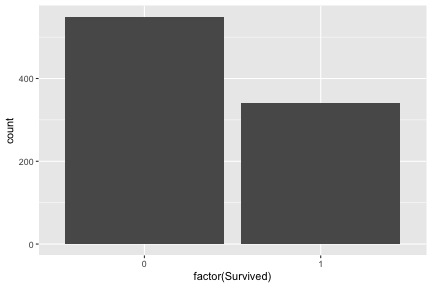

In [70]:
%%R -i titanic -w 6 -h 4 -u in

ggplot(titanic, aes(x=factor(Survived))) + geom_bar()

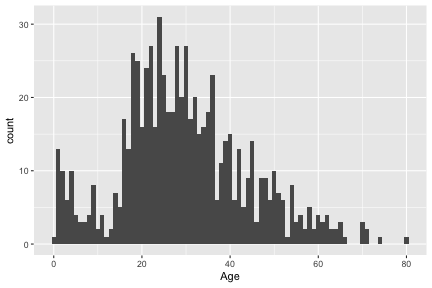

In [85]:
%%R -i titanic -w 6 -h 4 -u in

ggplot(titanic, aes(x=Age)) + geom_histogram(binwidth=1)

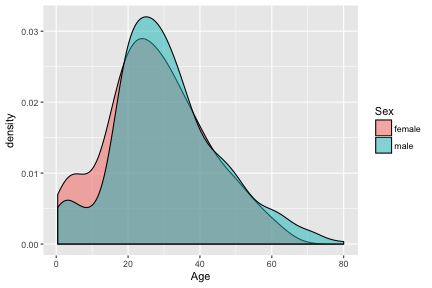

In [91]:
%%R -i titanic -w 6 -h 4 -u in

ggplot(titanic, aes(x=Age, fill=Sex)) + geom_density(alpha=0.5)

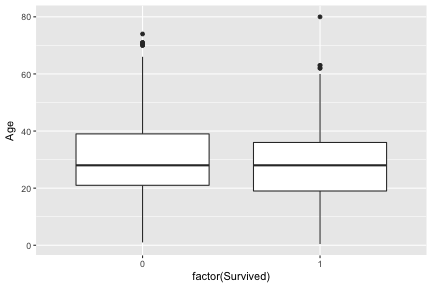

In [93]:
%%R -i titanic -w 6 -h 4 -u in

ggplot(titanic, aes(x=factor(Survived), y=Age)) + geom_boxplot()

In [ ]:
# https://github.com/savarin/pyconuk-introtutorial

In [115]:
# Preparing titanic dataset to fit into a classifier

titanic = pd.read_csv('./data/titanic.csv')

titanic = titanic.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

titanic['Age'] = titanic['Age'].fillna(titanic['Age'].mean())

mode_embarked = mode(titanic['Embarked'].fillna(''))[0][0]
titanic['Embarked'] = titanic['Embarked'].fillna(mode_embarked) # Replace with the most frequent

titanic['Sex'] = titanic['Sex'].map({'female': 0, 'male': 1}).astype(int)

titanic = pd.concat([titanic, pd.get_dummies(titanic['Embarked'], prefix='Embarked')], axis=1)

titanic = titanic.drop(['Embarked'], axis=1)

/Users/crscardellino/.local/miniconda/envs/mdscba/lib/python3.6/site-packages/scipy/stats/stats.py:253: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [198]:
titanic_train_data, titanic_test_data, titanic_train_target, titanic_test_target =\
    train_test_split(titanic.iloc[:,1:], titanic.iloc[:,0])

results = []

for model in (LinearSVC, LogisticRegression, DecisionTreeClassifier, RandomForestClassifier):
    clf = model()
    clf.fit(titanic_train_data, titanic_train_target)
    
    precision, recall, fscore, _ = precision_recall_fscore_support(titanic_test_target,
                                                                   clf.predict(titanic_test_data))

    for survived in (0, 1):
        results.append({
            'classifier': model.__name__,
            'survived': survived,
            'precision': precision[survived],
            'recall': recall[survived],
            'fscore': fscore[survived]
        })
        
results = pd.DataFrame(results, columns=['classifier', 'survived', 'precision', 'recall', 'fscore'])

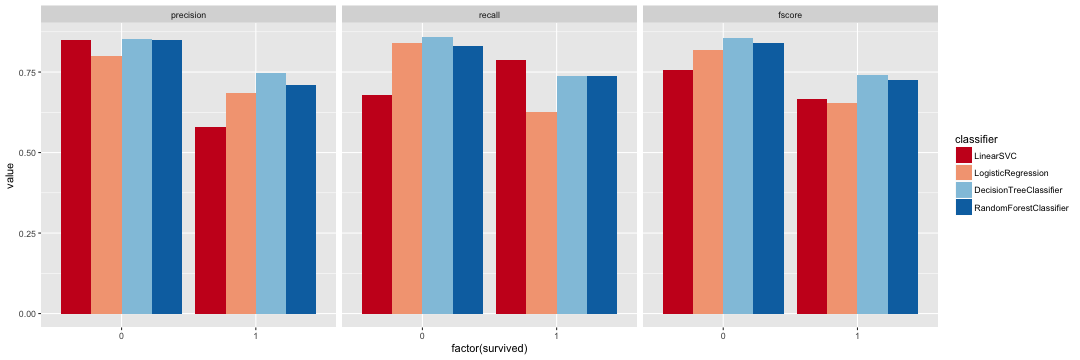

In [202]:
%%R -i results -w 15 -h 5 -u in

results <- melt(results, id.vars = c('classifier', 'survived'), variable.name = 'metric')

results$classifier <- factor(results$classifier,
                             levels=c('LinearSVC', 'LogisticRegression',
                                      'DecisionTreeClassifier', 'RandomForestClassifier'))

ggplot(results, aes(x = factor(survived), y=value, fill=classifier)) +
    geom_bar(stat='identity', position='dodge') + facet_wrap(~metric, nrow=1) +
    scale_fill_brewer(palette='RdBu')

In [200]:
learning_curve_results = []

for model in (LinearSVC, LogisticRegression, DecisionTreeClassifier, RandomForestClassifier):
    train_sizes, train_scores, validation_scores = \
        learning_curve(model(), titanic.iloc[:,1:], titanic.iloc[:,1], cv=10)
    
    train_scores_mean = train_scores.mean(axis=1)
    train_scores_std = train_scores.std(axis=1)
    validation_scores_mean = validation_scores.mean(axis=1)
    validation_scores_std = validation_scores.std(axis=1)
    
    for iteration in np.arange(train_sizes.shape[0]):
        learning_curve_results.append({
            'classifier': model.__name__,
            'data_size': train_sizes[iteration],
            'data_split': 'train',
            'score_mean': train_scores_mean[iteration],
            'score_std': train_scores_std[iteration]
        })
        
        learning_curve_results.append({
            'classifier': model.__name__,
            'data_size': train_sizes[iteration],
            'data_split': 'validation',
            'score_mean': validation_scores_mean[iteration],
            'score_std': validation_scores_std[iteration]
        })
    
learning_curve_results = pd.DataFrame(learning_curve_results)

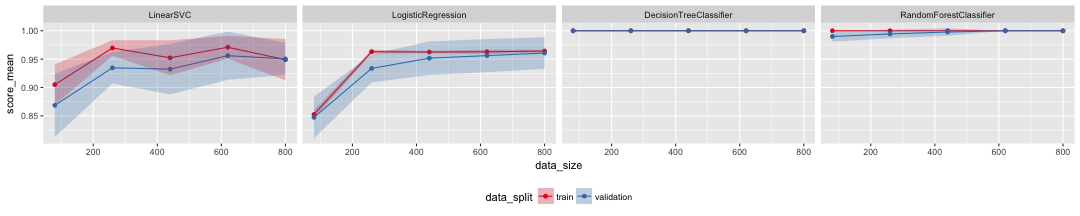

In [207]:
%%R -i learning_curve_results -w 15 -h 3 -u in

learning_curve_results$classifier <- factor(learning_curve_results$classifier,
                                            levels=c('LinearSVC', 'LogisticRegression',
                                                     'DecisionTreeClassifier', 'RandomForestClassifier'))

ggplot(learning_curve_results, aes(x=data_size)) +
    geom_line(aes(y=score_mean, color=data_split)) +
    geom_point(aes(y=score_mean, color=data_split)) +
    geom_ribbon(aes(ymin=score_mean-score_std, ymax=score_mean+score_std, fill=data_split), alpha=0.25) +
    facet_wrap(~classifier, nrow=1) +
    theme(legend.position='bottom') +
    scale_color_brewer(palette='Set1') + scale_fill_brewer(palette='Set1')